# Nobel Model

Úlohy:
1. Losovat úmrtí
2. Losovat vakcinaci
3. Ty, kde vakcinace - úmrtí <= 14 dnů => nevakcinovat
4. S pravděpodobností P lidi z bodu 3. necháme zemřít


In [1]:
from tqdm.contrib.concurrent import process_map
from matplotlib import pyplot as plt
from common import *

import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
sns.set_theme()

In [3]:
RESULTS_DIR = "result"
COLORS = "bgrcmyk"

## Load data

In [4]:
df_deaths = pd.read_csv(DEATHS_FILE)
df_vacc = pd.read_csv(VACCINATION_FILE)
df_counts = pd.read_csv(COUNTS_FILE)

### Sanity checks

In [5]:
assert len(df_deaths) >= len(df_vacc.drop(columns="poradi_davky").groupby(["tyden", "vek"]).sum()), "Cropping applied?"
assert len(df_deaths["tyden"].unique()) == len(df_vacc["tyden"].unique()), "Weeks are not the same!"
assert len(df_deaths["vek"].unique()) == len(df_vacc["vek"].unique()) == len(df_counts["vek"].unique()), "Age groups are not the same!"

In [6]:
# Convert weeks to timestamps in seconds
df_vacc["tyden"] = pd.to_datetime(df_vacc["tyden"] + "-1", format="%Y-W%W-%w").astype("int64") // 10**9
df_deaths["tyden"] = pd.to_datetime(df_deaths["tyden"] + "-1", format="%Y-W%W-%w").astype("int64") // 10**9

### Preview

In [7]:
df_deaths

,tyden,vek,umrti
0,1609113600,0-29,24
1,1609113600,30-39,27
2,1609113600,40-49,69
3,1609113600,50-59,168
4,1609113600,60-69,428
...,...,...,...
765,1674432000,30-39,15
766,1674432000,40-49,54
767,1674432000,50-59,133
768,1674432000,60-69,301


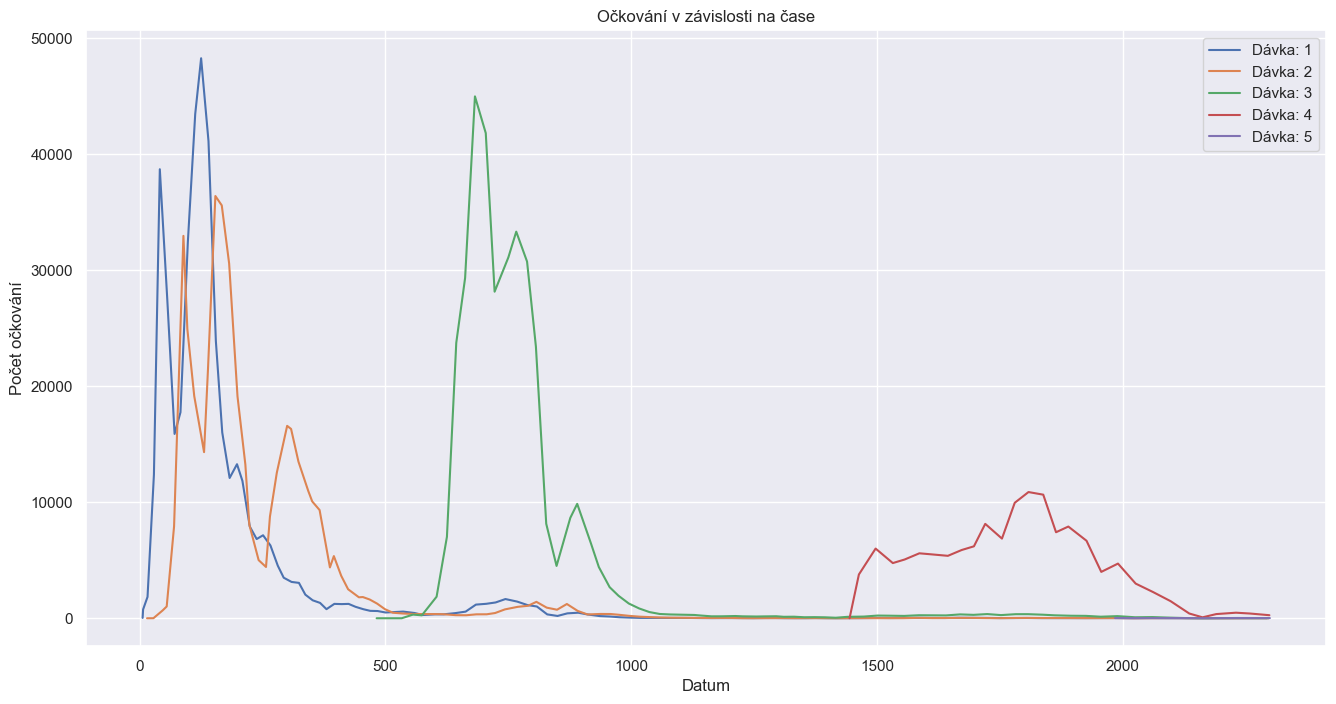

In [8]:
plt.figure(figsize=(16, 8))
for i in range(1, df_vacc.poradi_davky.max()):
    df_vacc[(df_vacc.vek == "80-129") & (df_vacc.poradi_davky == i)]["pocet_davek"].plot(label=f"Dávka: {i}")

plt.legend()
plt.ylabel("Počet očkování")
plt.xlabel("Datum")
plt.title("Očkování v závislosti na čase")
plt.savefig(os.path.join(RESULTS_DIR, "vaccination.png"), facecolor="white", transparent=False);

In [9]:
df_counts

,vek,celkem
0,0-29,3259827
1,30-39,1409650
2,40-49,1735533
3,50-59,1354501
4,60-69,1284689
5,70-79,1037997
6,80-129,441970


## Preparations

In [10]:
# We will only use first dose
df_vacc = df_vacc[df_vacc.poradi_davky == 1].drop(columns="poradi_davky")

In [63]:
P = 0
RUN_COUNT = 100
TIMEDELTA_WEEKS = 2
TIMEDELTA = timedelta(weeks=TIMEDELTA_WEEKS).total_seconds()

In [64]:
def run(p):
    # Data variables
    people = {}
    
    # Variables for metrics
    count_vacc_after_death = 0
    count_vacc_timedelta_death = 0
    count_vacc_same_as_death = 0
    x, y11, y12, y21, y22 = {}, {}, {}, {}, {}
    death_vacc_date = {}
    
    # Generate vaccination and death date based on reality for reach person
    for row_counts in df_counts.itertuples():
        # Select rows for age group
        dfs_deaths_sel = df_deaths[df_deaths.vek == row_counts.vek]
        dfs_vacc_sel = df_vacc[df_vacc.vek == row_counts.vek]

        # Append None to the end of the array (= no death & no vaccination classes)
        da = np.append(dfs_deaths_sel.tyden, None)
        va = np.append(dfs_vacc_sel.tyden, None)

        # Append count to the end of the array for assignation with da and va (people with no death/vaccination)
        dp = np.append(dfs_deaths_sel.umrti, row_counts.celkem - dfs_deaths_sel.umrti.sum())
        vp = np.append(dfs_vacc_sel.pocet_davek, row_counts.celkem - dfs_vacc_sel.pocet_davek.sum())

        # Normalize (so that the sum is 1), then randomly choice dates of death/vaccination
        dates_death = np.random.choice(da, row_counts.celkem, p=dp / dp.sum())
        dates_vacc = np.random.choice(va, row_counts.celkem, p=vp / vp.sum())

        # print(f"Dead: {len(dates_death[dates_death != None])}/{dfs_deaths_sel.umrti.sum()}")

        # Assign dates for each person
        for n in range(row_counts.celkem):
            date_death = dates_death[n]
            date_vacc = dates_vacc[n]

            if date_vacc is not None and date_death is not None:
                # Invalid assigment
                if date_vacc > date_death:
                    count_vacc_after_death += 1
                    date_vacc = None

                # Modeled 
                elif date_vacc + TIMEDELTA > date_death:
                    #if date_vacc == date_death:
                    #    if np.random.random() < 0.5:
                    #        count_vacc_same_as_death += 1
                    #        date_vacc = None
                            
                    if date_vacc is not None and np.random.random() < p:
                        count_vacc_timedelta_death += 1
                        date_vacc = None

            people.setdefault(row_counts.vek, []).append({"dead": date_death, "vaccinated": date_vacc})
    
    for age in people:
        for p in people[age]:
            if p["dead"] is not None and p["vaccinated"] is not None:
                key = (datetime.fromtimestamp(p["dead"]) - datetime.fromtimestamp(p["vaccinated"])).days // 7
                
                if age not in death_vacc_date:
                    death_vacc_date[age] = {}
                    
                if key not in death_vacc_date[age]:
                    death_vacc_date[age][key] = 0
                    
                death_vacc_date[age][key] += 1

    # print(f"Vakcinováno po úmrtí: {count_vacc_after_death}")
    # print(f"Odebráno pro jev {p=}: {count_vacc_timedelta_death}");
    
    # Create report for graphs based on dates generated above
    for week in np.unique(df_deaths["tyden"]):
        for age, people_age in people.items():
            deaths_vacc = 0
            deaths_norm = 0
            alive_vacc = 0
            alive_norm = 0

            for i in people_age:
                # If selected person won't die in the simulation or die somewhere in the future
                if i["dead"] is None or i["dead"] > week:
                    if i["vaccinated"] is None or i["vaccinated"] > week:
                        alive_norm += 1
                    else:
                        alive_vacc += 1
                
                # If selected person is going to die this week
                elif i["dead"] == week:
                    # There is no need to check for bigger than death, it is filtered before
                    if i["vaccinated"] is None or i["vaccinated"] > week:
                        deaths_norm += 1
                    else:
                        deaths_vacc += 1

            # Save
            x.setdefault(age, []).append(datetime.fromtimestamp(week))
            y11.setdefault(age, []).append(deaths_vacc)
            y12.setdefault(age, []).append(alive_vacc)
            y21.setdefault(age, []).append(deaths_norm)
            y22.setdefault(age, []).append(alive_norm)
    
    return x, y11, y12, y21, y22, death_vacc_date, count_vacc_after_death, count_vacc_timedelta_death

## Simulation

In [65]:
data = process_map(run, [P] * RUN_COUNT, max_workers=os.cpu_count())

  0%|          | 0/100 [00:00<?, ?it/s]

## Save data

In [51]:
with open(os.path.join(RESULTS_DIR, f"{TIMEDELTA_WEEKS=}__{P=}__data.pickle"), "wb") as f:
    pickle.dump(data, f)

## Load data

In [68]:
with open(os.path.join(RESULTS_DIR, f"{TIMEDELTA_WEEKS=}__{P=}__data.pickle"), "rb") as f:
    data = pickle.load(f)

## Visualizations

### Počet živých kumulativně

In [69]:
for directory, label in [
        ("alive_cumulative", "Počet živých lidí (kumulativně) dle vakcinance v čase"), 
        ("alive_derivative", "Počet živých lidí (derivace) dle vakcinance v čase"),
        ("dead", "Počet mrtvých lidí dle vakcinance v čase")
]:
    current_directory = os.path.join(RESULTS_DIR, directory)
    os.makedirs(current_directory, exist_ok=True)

    for age_n, (age_low, age_up) in enumerate(AGE_CATEGORIES):
        age_category = f"{age_low}-{age_up}"

        fig, (al, ar) = plt.subplots(1, 2, sharey="row", figsize=(18, 6))
        was = set()
        
        data_y1_mean = []
        data_y2_mean = []

        for x, y11, y12, y21, y22, death_vacc, errored, removed in data:
            for age in list(y12.keys()):
                if age == age_category:
                    if directory == "alive_derivative":
                        data_x = x[age][1:]
                        data_y1 = np.diff(y12[age])
                        data_y2 = np.diff(y22[age])
                        
                    elif directory == "alive_cumulative":
                        data_x = x[age]
                        data_y1 = y12[age]
                        data_y2 = y22[age]
                    
                    elif directory == "dead":
                        data_x = x[age]
                        data_y1 = y11[age]
                        data_y2 = y21[age]
                    else:
                        raise Exception("Something went really wrong.")
                    
                    data_y1_mean.append(data_y1)
                    data_y2_mean.append(data_y2)
                    
                    al.plot(data_x, data_y1, color=COLORS[age_n], alpha=1 / RUN_COUNT, label=age if age not in was else None)
                    ar.plot(data_x, data_y2, color=COLORS[age_n], alpha=1 / RUN_COUNT, label=age if age not in was else None)
                    was.add(age)
                    
        data_y1_mean = np.mean(data_y1_mean, axis=0)
        data_y2_mean = np.mean(data_y2_mean, axis=0)
        
        al.plot(data_x, data_y1_mean, color=COLORS[age_n], alpha=1, linewidth=3, label=f"{age_category} => průměr")
        ar.plot(data_x, data_y2_mean, color=COLORS[age_n], alpha=1, linewidth=3, label=f"{age_category} => průměr")

        al.set_xlabel("Datum")
        ar.set_xlabel("Datum")

        al.set_ylabel(" ".join(label.split()[:2]))

        al.set_title("Vakcinovaní")
        ar.set_title("Nevakcinovaní")

        al.legend()
        ar.legend()

        fig.suptitle(label + f" pro {P=}, {TIMEDELTA_WEEKS=} a věkovou skupinu {age}");
        plt.savefig(os.path.join(current_directory, f"age={age_category}__{TIMEDELTA_WEEKS=}__{P=}.png"), facecolor="white", transparent=False)

        plt.clf();

/tmp/ipykernel_9977/1290256175.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (al, ar) = plt.subplots(1, 2, sharey="row", figsize=(18, 6))


<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

### Účinnost, počet úmrtí pro daný týden od vakcinace

In [66]:
for directory, label in [
        ("efficacy", "Účinnost vakcíny"),
        ("death_vacc", "Počet úmrtí pro daný týden od vakcinace")
]:
    current_directory = os.path.join(RESULTS_DIR, directory)
    os.makedirs(current_directory, exist_ok=True)

    for age_n, (age_low, age_up) in enumerate(AGE_CATEGORIES):
        age_category = f"{age_low}-{age_up}"

        plt.figure(figsize=(16, 9))
        was = set()
        data_y_mean = []

        for x, y11, y12, y21, y22, death_vacc, errored, removed in data:
            for age in list(death_vacc.keys()):
                if age == age_category:
                    if directory == "efficacy":
                        data_x = x[age]
                        data_y = 1 - (np.array(y11[age]) / np.array(y12[age])) / (np.array(y21[age]) / np.array(y22[age]))
                        
                        plt.ylim(-1, 1)
                        plt.xlabel("Datum")
                    
                    elif directory == "death_vacc":
                        # Add missing values (nobody died)
                        for i in range(len(x)):
                            if i not in death_vacc[age]:
                                death_vacc[age][i] = 0
                                
                        # Sort it
                        death_vacc_selection = dict(sorted(death_vacc[age].items()))
                        
                        data_x = death_vacc_selection.keys()
                        data_y = list(death_vacc_selection.values())
                        
                        plt.xlabel("Týden úmrtí po vakcinaci")
                        
                    else:
                        raise Exception("Something went really wrong.")
                        
                    data_y_mean.append(data_y)
                        
                    plt.plot(data_x, data_y, color=COLORS[age_n], alpha=1 / RUN_COUNT * 5, label=age if age not in was else None)
                    was.add(age)

        data_y_mean = np.mean(data_y_mean, axis=0)
        plt.plot(data_x, data_y_mean, color=COLORS[age_n], alpha=1, linewidth=3, label=f"{age_category} => průměr")
        
        
        plt.ylabel(" ".join(label.split()[:2]))

        plt.legend()

        plt.title(label + f" pro {P=}, {TIMEDELTA_WEEKS=} a věkovou skupinu {age}")
        plt.savefig(os.path.join(current_directory, f"age={age_category}__{TIMEDELTA_WEEKS=}__{P=}.png"), facecolor="white", transparent=False)

        plt.clf()

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>